Approach of GAN:

<img src="https://i.imgur.com/6NMdO9u.png" style="width:420px; margin-bottom:32px"/>

GAN có 2 mạng neural: Generator và Discriminator. Generator sẽ tạo ra "fake" sample dựa trên một vector/matrix ngẫu nhiên, và Discriminator cố gắng phát hiện xem sample đó có phải là "thật" (được chọn từ dữ liệu huấn luyện), hay là "giả" (được tạo ra bởi Generator). Việc huấn luyện diễn ra đồng thời: Chúng ta huấn luyện Discriminator trong vài epoch, sau đó huấn luyện Generator trong vài epoch. Cứ lặp lại như thế. Điều này giúp cả Generator và Discriminator trở nên tốt hơn

In [1]:
project_name = '06b-anime-dcgan'

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
# import opendatasets as od

# dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
# od.download(dataset_url)



In [4]:
import os
DATA_DIR = "/kaggle/input/animeface"
os.listdir(DATA_DIR)

['faces']

Load dataset sử dụng `ImageFolder` của `torchvision`. Ta cũng sẽ resize và cắt ảnh về 64x64px, chuẩn hóa các giá trị pixel mean và độ lệch chuẩn là 0.5 đối với mỗi kênh. Điều này đảm bảo rằng các giá trị pixel nằm trong khoản (-1,1), which is more convenient for training the discriminator. Sau đó tạo dataloader để load data theo batches.

In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, .5, .5), (.5, .5, .5)

print(stats)

((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))


In [7]:
train_ds = ImageFolder(DATA_DIR, transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

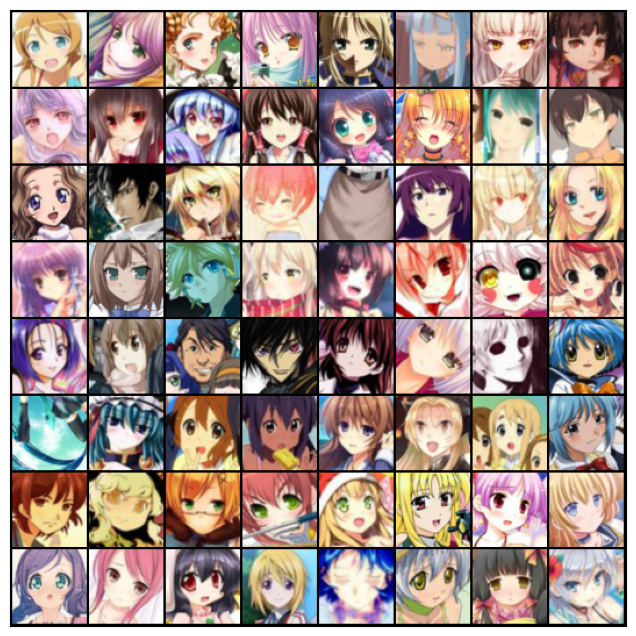

In [11]:
show_batch(train_loader)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Moving data to device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    else:
        return data.to(device, non_blocking = True)

In [13]:
class DeviceDataLoader():
    def __init__(self, loader, device):
        self.loader = loader
        self.device = device
        
    def __iter__(self):
        for x in self.loader:
            yield to_device(x, self.device)
    
    def __len__(self):
        return len(self.loader)

In [14]:
device = get_default_device()

In [15]:
device

device(type='cuda')

In [16]:
train_loader = DeviceDataLoader(train_loader, device)

# Mạng Discriminator

Discriminator sẽ nhận vào một ảnh, cố gắng xác định xem nó là "Thật" (thuộc về training dataset) hoặc là "Generated" (đc sinh ra từ Generator). Như những mạng neural khác, ta sẽ sử dụng CNN để tạo ra một đầu ra số duy nhất cho mỗi bức ảnh. Ta sẽ sử dụng stride = 2 để dần dần giảm size của feature map đầu ra

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [17]:
import torch.nn as nn

In [18]:
discriminator = nn.Sequential(
    #in: 3 x 64 x 64
    
    nn.Conv2d(3, 64, kernel_size=4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    #out: 64 x 32 x 32
    
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()


)

Lưu ý rằng chúng tôi đang sử dụng hàm kích hoạt Leaky ReLU cho máy phân biệt.

<img src="https://vidyasheela.com/web-contents/img/post_img/41/leaky-ReLU-activation-function-new.png" width="420">

>   Khác với hàm ReLU thông thường, Leaky ReLU cho phép thông qua một tín hiệu gradient nhỏ cho các giá trị âm. Kết quả là, nó làm cho các gradient từ máy phân biệt chảy mạnh hơn vào máy tạo. Thay vì truyền một gradient (độ dốc) bằng 0 trong quá trình lan truyền ngược, nó truyền một gradient âm nhỏ. - [Source](https://sthalles.github.io/advanced_gans/)


    

Giống như bất kỳ mô hình phân loại nhị phân nào khác, đầu ra của máy phân biệt là một số duy nhất nằm giữa 0 và 1, có thể được hiểu là xác suất của hình ảnh đầu vào là thật, tức là được chọn từ tập dữ liệu gốc.

Hãy di chuyển mô hình máy phân biệt đến thiết bị được chọn.

In [19]:
discriminator = to_device(discriminator, device)
    

In [20]:
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

# Mạng Generator

Đầu vào của mạng generator là một vector hoặc ma trận giá trị ngẫu nhiên (latent tensor), dùng như là seed để tạo ảnh. Generator sẽ chuyển tensor shape (128, 1, 1) sang tensor ảnh có shape là (3 x 28 x 28). Để làm đc điều này thì ta dùng `ConvTranspose2D` từ PyTorch, sử dụng như một phép Giải Tích chập

In [21]:
latent_size = 128

In [22]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Ta sẽ dùng hàm TanH cho lớp đầu ra của Generator
<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

ReLU được sử dụng trong mạng Generator nhưng ở đầu ra thì lại sử dụng hàm TanH. Chúng tôi thấy rằng, việc sử dụng một hàm kích hoạt có giới hạn cho phép mô hình học nhanh hơn để bõa hòa và bao phủ không gian màu của phân phối tập huấn luyện. Trong Discriminator, chúng tôi thấy rằng sử dụng leaky ReLU hoạt động tốt, đặc biệt là với mô hình hóa ở độ phân giải cao. [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)

Vì đầu ra của hàm TanH nằm giữa khoảng [-1,1], do đó ta áp dụng phép biến đổi tương tự lên ảnh trong tập huấn luyện. Hãy thử tạo ra một số output sử dụng Generator và show chúng ra bằng phép biến đổi và denormalizing output

In [23]:
xb = torch.randn(batch_size, latent_size, 1, 1)

In [24]:
fake_images = generator(xb)
fake_images.shape

torch.Size([128, 3, 64, 64])

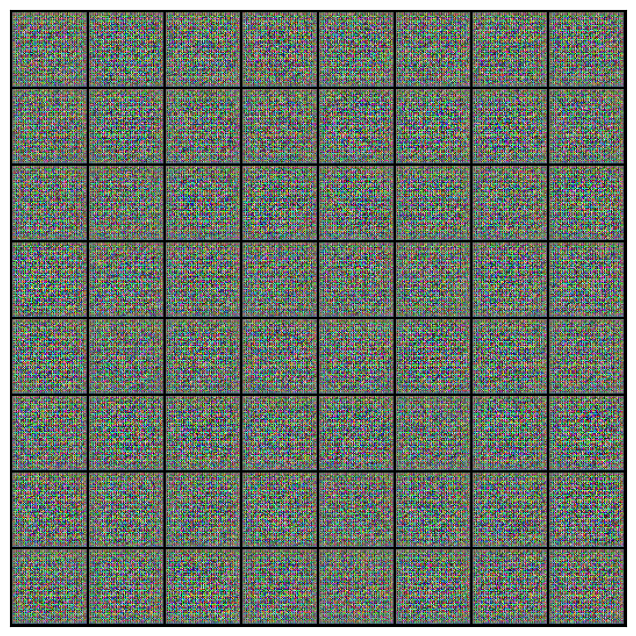

In [25]:
show_images(fake_images)

Ảnh rất nhiễu, vì ta chưa huấn luyện cho Generator

In [26]:
generator = to_device(generator, device)

In [27]:
generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

# Training Discriminator
Vì Discriminator là mô hình phân loại nhị phân, ta sẽ sử dụng binary cross entropy loss để đánh giá mức độ tốt mà mô hình có thể phân biệt đc ảnh thật và ảnh được generate ra 

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

# **Các bước để huấn luyện Discriminator như sau:**
* Ta sẽ mong muốn discriminator cho ra output 1 nếu mà ảnh được lấy từ bộ Training, và sẽ cho ra 0 nếu là ảnh sinh ra từ Generator
* Đầu tiên, cho 1 batch của ảnh thật qua discriminator, đặt targets label là 1, và tính loss (real_loss), là loss của 1 lô (batch) ảnh thật, real_score
* Sau đó, ta sẽ đưa 1 batch ảnh giả (Sinh ra bởi Generator) qua Discriminator, tính fake_loss, fake_score
* Tính tổng loss = real_loss + fake_loss. Đạo hàm loss và cập nhật trọng số

In [28]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    #Generate fake images
    latent = torch.randn(batch_size, latent_size, 1,1, device =device)
    fake_images = generator(latent)
    
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# **Huấn luyện Generator**
Vì output của Generator là ảnh, do đó cách mà ta train Generator khá là không rõ ràng. Ta sẽ sử dụng trick, nó sẽ đẩy Discriminator như là 1 phần của Loss function. Cụ thể như sau
* Ta sẽ sinh 1 batch ảnh sử dụng Generator, đưa chúng vào Discriminator.
* Tính loss bằng cách đặt target labels là 1. Bởi vì ta đang muốn Generator đánh lừa Discriminator.
* Ta sử dụng loss để thực hiện grad descent, càng ngày nó sẽ sinh được ảnh tốt hơn để đánh lừa được Discriminator

In [29]:
def train_generator(opt_g):
    #Clear generator gradients
    opt_g.zero_grad()
    
    #Generate fake images
    latent = torch.randn(batch_size, latent_size, 1,1, device = device)
    fake_images = generator(latent)
    
    #Try to fool discriminator
    fake_preds = discriminator(fake_images)
    fool_targets = torch.ones(batch_size, 1, device = device )
    loss = F.binary_cross_entropy(fake_preds, fool_targets)
    
    loss.backward()
    opt_g.step()
    return loss.item()



In [30]:
from torchvision.utils import save_image

In [31]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [32]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [33]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


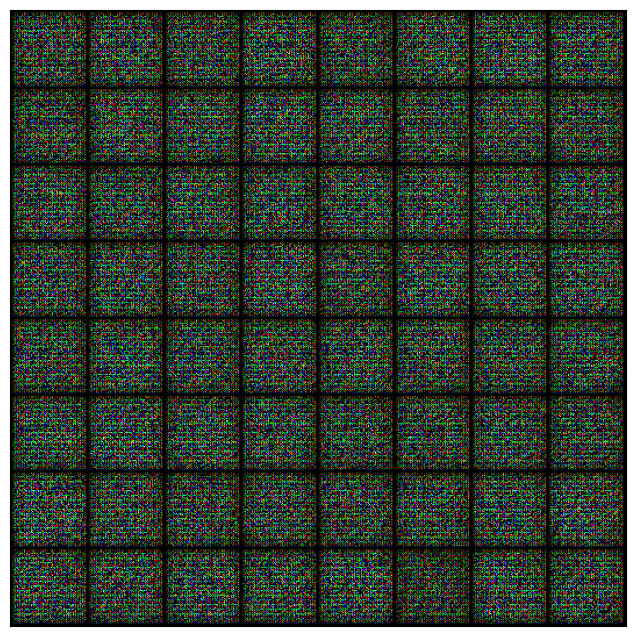

In [34]:
save_samples(0, fixed_latent)

# Full Training Loop

Định nghĩa hàm `fit` để huấn luyện Discriminator và Generator cho từng batch dữ liệu. Ta sẽ dùng optimizer  Adam cùng với một số tham số custom hoạt động tốt với GANs. Ta sẽ lưu một số ảnh sinh ra ở giai đoạn giữa 
 <img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>
 

In [35]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [36]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_loader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [37]:
lr = 0.0002
epochs = 25

In [38]:
history = fit(epochs, lr)

  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 3.5420, loss_d: 0.6737, real_score: 0.6555, fake_score: 0.0646
Saving generated-images-0001.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 3.7101, loss_d: 0.4231, real_score: 0.7986, fake_score: 0.1449
Saving generated-images-0002.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 5.7117, loss_d: 0.0718, real_score: 0.9688, fake_score: 0.0378
Saving generated-images-0003.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 4.2422, loss_d: 0.1561, real_score: 0.8855, fake_score: 0.0239
Saving generated-images-0004.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 3.6544, loss_d: 0.1614, real_score: 0.9026, fake_score: 0.0473
Saving generated-images-0005.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 7.8378, loss_d: 0.2739, real_score: 0.9942, fake_score: 0.2106
Saving generated-images-0006.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 5.4522, loss_d: 0.0394, real_score: 0.9672, fake_score: 0.0045
Saving generated-images-0007.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 6.0185, loss_d: 0.2020, real_score: 0.9997, fake_score: 0.1645
Saving generated-images-0008.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 8.8097, loss_d: 0.2231, real_score: 0.8151, fake_score: 0.0006
Saving generated-images-0009.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 7.3834, loss_d: 0.0138, real_score: 0.9870, fake_score: 0.0007
Saving generated-images-0010.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 4.8829, loss_d: 0.0572, real_score: 0.9568, fake_score: 0.0114
Saving generated-images-0011.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 6.2791, loss_d: 0.0711, real_score: 0.9352, fake_score: 0.0011
Saving generated-images-0012.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 5.4058, loss_d: 0.0520, real_score: 0.9732, fake_score: 0.0230
Saving generated-images-0013.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 4.9326, loss_d: 0.0491, real_score: 0.9827, fake_score: 0.0301
Saving generated-images-0014.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 4.7779, loss_d: 0.0980, real_score: 0.9594, fake_score: 0.0502
Saving generated-images-0015.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 8.1486, loss_d: 0.4290, real_score: 0.9750, fake_score: 0.2772
Saving generated-images-0016.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.0471, loss_d: 0.1266, real_score: 0.9376, fake_score: 0.0451
Saving generated-images-0017.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 4.8854, loss_d: 0.0115, real_score: 0.9983, fake_score: 0.0097
Saving generated-images-0018.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.7119, loss_d: 0.0557, real_score: 0.9874, fake_score: 0.0406
Saving generated-images-0019.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 5.5750, loss_d: 0.1244, real_score: 0.9945, fake_score: 0.1030
Saving generated-images-0020.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 8.7327, loss_d: 0.0103, real_score: 0.9921, fake_score: 0.0021
Saving generated-images-0021.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 9.0843, loss_d: 0.2216, real_score: 0.8258, fake_score: 0.0000
Saving generated-images-0022.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.6560, loss_d: 0.1279, real_score: 0.9814, fake_score: 0.0899
Saving generated-images-0023.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 7.3577, loss_d: 0.1647, real_score: 0.9949, fake_score: 0.1321
Saving generated-images-0024.png


  0%|          | 0/801 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.1751, loss_d: 2.4930, real_score: 0.1269, fake_score: 0.0000
Saving generated-images-0025.png


In [39]:
losses_g, losses_d, real_scores, fake_scores = history

In [40]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [41]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


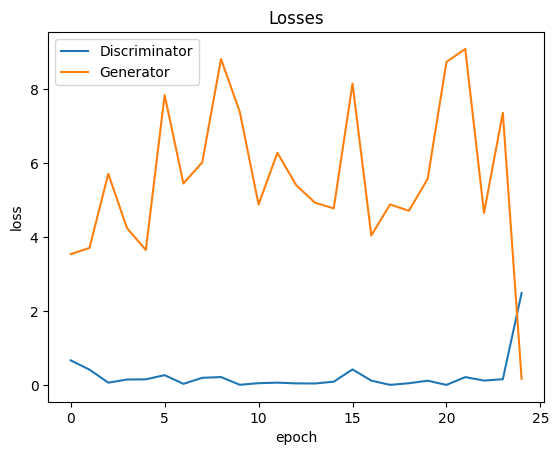

In [42]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

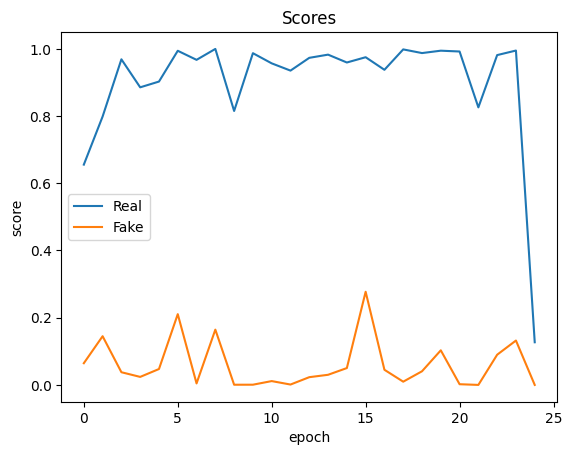

In [43]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');